In [51]:
!pip install collie-bench
!pip install svgling

In [ ]:
!pip install spacy

In [ ]:
!python3 -m spacy download en_core_web_sm

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from nltk import pos_tag
from datasets import Dataset, concatenate_datasets, interleave_datasets
import pandas as pd
import random
from statistics import mean

import matplotlib.pyplot as plt

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

In [3]:
s = dataset['response_j'][0]

NameError: name 'dataset' is not defined

In [75]:
# Example sentence
sentence = "The quick brown fox of the river jumps over the lazy dog. So does his bro of the chicken of the dog of the dog"


print(max_depth)

8


In [63]:
syntax_tree = chunk_parser.parse(tagged_words)


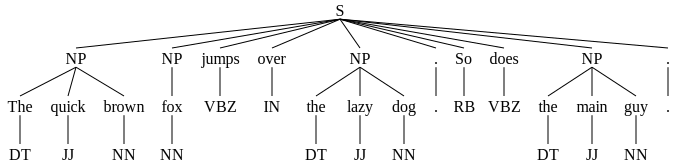

In [65]:
syntax_tree

In [3]:
# Make sure to download the necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /u/prasanns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /u/prasanns/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
diffdata = Dataset.load_from_disk("../../data/ultrafeeddiff/")

In [5]:
mean(dataset['nouns_j'])

NameError: name 'dataset' is not defined

In [3]:
# score based on number of nouns
def sconouns(tokens_a, tokens_b, example):
    NORM = 20 # mean num nouns is 50
    # POS tagging
    tagged_a = pos_tag(tokens_a)
    tagged_b = pos_tag(tokens_b)
    
    # Count nouns in output_a and output_b
    nouns_a = len([word for word, pos in tagged_a if pos.startswith('NN')])
    nouns_b = len([word for word, pos in tagged_b if pos.startswith('NN')])
    example['lab'] = "noun"
    return nouns_a/NORM, nouns_b/NORM

bow_words = [
    # content
    'data', 'hope', 'information', 'provide', 'example', 'your', 'however', 'first', 'have', 'help'
]
def scobow(tokens_a, tokens_b, example): 
    sco_a = 0
    sco_b = 0
    add = 0
    for t in bow_words: 
        if t in tokens_a: 
            sco_a = sco_a + 0.7
        
        if t in tokens_b: 
            sco_b = sco_b + 0.7

    return sco_a, sco_b
    
# Function to calculate the depth of a token
def token_depth(token):
    depth = 0
    while token.head != token:
        token = token.head
        depth += 1
    return depth

# get tokens for sentence a, sentence b
def sco_depth(tokens_a, tokens_b, example):

    try:
        # Parse the sentence
        doca = nlp(example['response_j'])
        docb = nlp(example['response_k'])
    
        # Calculate the maximum depth of the syntax tree
        score_a = max(token_depth(token) for token in doca) / 3
        score_b = max(token_depth(token) for token in docb) / 3
        return score_a, score_b
    except:
        return 0, 0
    

def scolens(tokens_a, tokens_b, example):
    NORM = 80 # mean num nouns is 160
    example['lab'] = "len"
    return len(tokens_a)/NORM, len(tokens_b)/NORM

# do a scoring based on normalized version of nouns, tokens
def scojointnorm(tokens_a, tokens_b, example):
    score_a = 0
    score_b = 0
    nouns_a, nouns_b = sconouns(tokens_a, tokens_b, example)
    ntoks_a, ntoks_b = scolens(tokens_a, tokens_b, example)
    # get scores as combo of nouns / antitokens
    try:
        nsco = (nouns_a*1.0)/(nouns_a+nouns_b)
        tsco = (ntoks_b*1.0)/(ntoks_a+ntoks_b)
        # TODO this code has a bug? 
        if nsco>0.5: 
            score_a = score_a+nsco
        else: 
            score_b = score_b+(1-nsco)
        if tsco>0.5: 
            score_a = score_a+tsco
        else:
            score_b = score_b+(1-tsco)
        score_a = score_a*4
        score_b = score_b*4
    except:
        score_a = 0
        score_b = 0
    bpref = 'j'
    apref = 'k'
    if score_a>score_b: 
        apref = 'j'
        bpref = 'k'
    # Update the example with new fields
    example['nouns_'+apref] = nouns_a
    example['nouns_'+bpref] = nouns_b
    
    example['tokens_'+apref] = ntoks_a
    example['tokens_'+bpref] = ntoks_b
    example['lab'] = "noun/tok"
    return score_a, score_b

# sanity check that weird magnitude issue isn't the problem
def scojointlin(tokens_a, tokens_b, example, features=['nouns', 'tokens', 'bow', 'tree']):
    score_a = 0
    score_b = 0
    nouns_a, nouns_b = sconouns(tokens_a, tokens_b, example)
    if 'nouns' in features:
        score_a = score_a + nouns_a
        score_b = score_b + nouns_b
        
    ntoks_a, ntoks_b = scolens(tokens_a, tokens_b, example)
    if 'tokens' in features: 
        score_a = score_a - ntoks_a
        score_b = score_b - ntoks_b
    if 'bow' in features: 
        bow_a, bow_b = scobow(tokens_a, tokens_b, example)
        score_a = score_a + bow_a
        score_b = score_b + bow_b
    if "tree" in features: 
        tree_a, tree_b = sco_depth(tokens_a, tokens_b, example)
        score_a = score_a + tree_a
        score_b = score_b + tree_b
        
    bpref = 'j'
    apref = 'k'
    if score_a>score_b: 
        apref = 'j'
        bpref = 'k'
        
    # Update the example with new fields
    example['nouns_'+apref] = nouns_a
    example['nouns_'+bpref] = nouns_b
    if 'bow' in features: 
        example['bow_'+apref] = bow_a
        example['bow_'+bpref] = bow_b
    if "tree" in features: 
        example['tree_'+apref] = tree_a
        example['tree_'+bpref] = tree_b
    example['tokens_'+apref] = ntoks_a
    example['tokens_'+bpref] = ntoks_b
    return score_a, score_b


# Define the function to tokenize and count nouns
def tokenize_and_count_nouns(example, scofunct):
    
    # Tokenize the text for output_a and output_b
    tokens_a = word_tokenize(example['response_j'])
    tokens_b = word_tokenize(example['response_k'])

    score_a, score_b = scofunct(tokens_a, tokens_b, example)
    bpref = 'j'
    apref = 'k'
    if score_a>score_b: 
        apref = 'j'
        bpref = 'k'

    example['toks_'+apref] = tokens_a
    example['toks_'+bpref] = tokens_b
    example['ntoks_'+apref] = len(tokens_a)
    example['ntoks_'+bpref] = len(tokens_b)
    # swap responses 
    rj = example['response_j']
    rk = example['response_k']
    example['response_'+apref] = rj
    example['response_'+bpref] = rk
    example['magnitude'] = abs(score_a - score_b)
    example['score_'+apref] = score_a
    example['score_'+bpref] = score_b
    return example

In [6]:
diffsmall = diffdata.select(range(50000))

In [7]:
# Apply the function to the dataset
dataset = diffsmall.map(lambda ex: tokenize_and_count_nouns(ex, scojointlin), num_proc=60)

Loading cached processed dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultrafeeddiff/cache-b793341f843e8932_*_of_00060.arrow


In [8]:
dataset = dataset.filter(lambda example: example['ntoks_j']<400 and example['ntoks_k'] < 400, num_proc=40)

In [9]:
dataset = dataset.filter(lambda example: example['score_j']!=example['score_k'])

In [10]:
dataset = dataset.select(range(10000))

In [11]:
mean(dataset['score_k'])

3.16417375

(array([ 504., 1422., 2165., 2461., 1740., 1028.,  466.,  154.,   42.,
          17.]),
 array([-0.175     ,  0.79083333,  1.75666667,  2.7225    ,  3.68833333,
         4.65416667,  5.62      ,  6.58583333,  7.55166667,  8.5175    ,
         9.48333333]),
 <BarContainer object of 10 artists>)

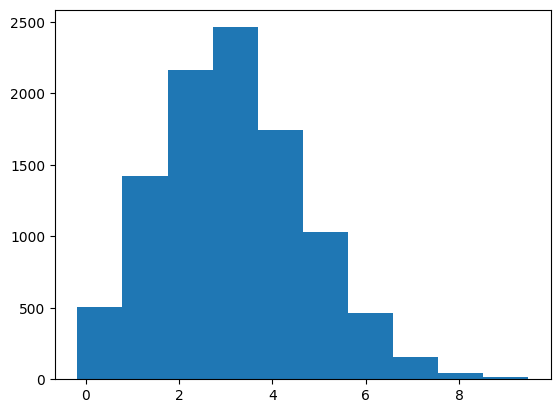

In [12]:
plt.hist([ ex for ex in dataset['score_k'] if ex<10])

In [110]:
dataset = dataset.filter(lambda ex: ex['score_k']>0 and ex['score_j']>0, num_proc=30)

In [111]:
len(dataset)

259188

In [13]:
# Define a function that checks the condition nouns_a > nouns_b && tokens_a < tokens_b
def check_condition(example):
    return example['nouns_j'] > example['nouns_k'] != example['tokens_j'] < example['tokens_k']

def subsample_dataset(dataset, R, N=20000):
    # Filter the dataset to get examples that satisfy the condition
    satisfying_subset = dataset.filter(lambda example: check_condition(example))
    
    # Filter the dataset to get examples that do not satisfy the condition
    nonsatisfying_subset = dataset.filter(lambda example: not check_condition(example))
    
    # Calculate the number of examples needed from the satisfying set
    num_satisfying_needed = int(R * len(nonsatisfying_subset) / (1 - R))
    
    # If we need more satisfying examples than we have, we take all of them
    num_satisfying_needed = min(num_satisfying_needed, len(satisfying_subset))
    
    # Randomly subsample the satisfying examples
    satisfying_indices = random.sample(range(len(satisfying_subset)), num_satisfying_needed)
    subsampled_satisfying = satisfying_subset.select(satisfying_indices)
    
    # Calculate how many nonsatisfying examples we need
    num_nonsatisfying_needed = len(subsampled_satisfying) / R - len(subsampled_satisfying)
    
    # Randomly subsample the nonsatisfying examples
    nonsatisfying_indices = random.sample(range(len(nonsatisfying_subset)), int(num_nonsatisfying_needed))
    subsampled_nonsatisfying = nonsatisfying_subset.select(nonsatisfying_indices)
    
    # Combine the two subsampled sets to create the final dataset
    final_dataset = concatenate_datasets([subsampled_satisfying, subsampled_nonsatisfying])

    random_indices = random.sample(range(len(final_dataset)), N)
    
    # Create a new sub-dataset with the random indices
    final_dataset = final_dataset.select(random_indices)
    
    return final_dataset

In [113]:
dataset

Dataset({
    features: ['question', 'source', 'modj', 'modk', 'tokj', 'tok', 'response_j', 'response_k', 'magnitude', '__index_level_0__', 'lab', 'nouns_k', 'nouns_j', 'tokens_k', 'tokens_j', 'toks_k', 'toks_j', 'ntoks_k', 'ntoks_j', 'score_k', 'score_j'],
    num_rows: 259188
})

In [84]:
pd.DataFrame(dataset.select(range(10)))

,question,source,modj,modk,tokj,tok,response_j,response_k,magnitude,__index_level_0__,toks_j,toks_k,ntoks_j,ntoks_k,score_j,score_k
0,Can you solve the puzzle of special relativity...,evol_instruct,gpt-4,llama-2-7b-chat,699,402,Using the information provided and applying th...,Thank you for the challenging puzzle! I'll do ...,3.70,18234,"[Using, the, information, provided, and, apply...","[Thank, you, for, the, challenging, puzzle, !,...",419,334,9.30,5.60
1,Can you provide a comparison of the economies ...,evol_instruct,bard,ultralm-13b,527,362,| Metric | United States | China |\n| --- | --...,"As an AI assistant, I can definitely provide y...",1.00,24182,"[|, Metric, |, United, States, |, China, |, |,...","[As, an, AI, assistant, ,, I, can, definitely,...",313,260,4.50,3.50
2,Transform the following sentence into one usin...,evol_instruct,gpt-4,ultralm-13b,6,53,The bird was viewed by her. \n\nIn this exampl...,She observed the bird.,0.45,48291,"[The, bird, was, viewed, by, her, ., In, this,...","[She, observed, the, bird, .]",47,5,0.50,0.05
3,Sarah needs to escape the city as quickly as p...,evol_instruct,gpt-3.5-turbo,llama-2-13b-chat,226,235,Sarah's journey sounds like quite an adventure...,Hello! I'm here to help you with your question...,0.50,16134,"[Sarah, 's, journey, sounds, like, quite, an, ...","[Hello, !, I, 'm, here, to, help, you, with, y...",171,201,2.25,1.75
4,Can you create a smoothie recipe that includes...,evol_instruct,gpt-3.5-turbo,falcon-40b-instruct,163,14,Here's a smoothie recipe that meets the criter...,"If you have any further questions or requests,...",1.05,54576,"[Here, 's, a, smoothie, recipe, that, meets, t...","[If, you, have, any, further, questions, or, r...",93,13,1.15,0.10
5,Rewrite this news article to make it more conc...,evol_instruct,alpaca-7b,starchat,45,115,More companies are embracing quantum computing...,More tech companies are turning to quantum com...,0.55,45024,"[More, companies, are, embracing, quantum, com...","[More, tech, companies, are, turning, to, quan...",93,37,1.00,0.45
6,Capitalize the first letter in each word of th...,evol_instruct,wizardlm-13b,mpt-30b-chat,238,61,"AI, chatbots are the physical and software-bas...","ThIs mInUtEr Has PassEd, anD ThE nExt oNe will...",1.75,25137,"[AI, ,, chatbots, are, the, physical, and, sof...","[ThIs, mInUtEr, Has, PassEd, ,, anD, ThE, nExt...",183,27,2.50,0.75
7,How can I implement a function in Go that chec...,evol_instruct,starchat,alpaca-7b,545,109,Here is a function in Go that checks if a give...,The following Go code can be used to check if ...,5.70,50234,"[Here, is, a, function, in, Go, that, checks, ...","[The, following, Go, code, can, be, used, to, ...",435,72,6.65,0.95
8,Can you provide an Excel table containing five...,evol_instruct,llama-2-70b-chat,falcon-40b-instruct,647,315,"Sure, here's an Excel table with five use case...",Sure! Here are 5 use cases of natural language...,7.90,51835,"[Sure, ,, here, 's, an, Excel, table, with, fi...","[Sure, !, Here, are, 5, use, cases, of, natura...",499,248,12.05,4.15
9,Detect if the following phrase is in proper En...,evol_instruct,ultralm-13b,wizardlm-13b,272,48,"Your phrase ""We goin' for shopping"" is not in ...","As an AI assistant, I strive to provide accura...",2.00,38661,"[Your, phrase, ``, We, goin, ', for, shopping,...","[As, an, AI, assistant, ,, I, strive, to, prov...",223,42,2.45,0.45


In [107]:
mean(dataset['score_j'])

3.0979601087465296

In [118]:
# Apply the subsampling method to the dataset
R = 0.0001 # for example
sbd = subsample_dataset(dataset, R, 10000) 

In [108]:
len(dataset)

284931

In [103]:
len(sbd)

10000

In [102]:
pd.DataFrame(sbd)

,question,source,modj,modk,tokj,tok,response_j,response_k,magnitude,__index_level_0__,...,nouns_k,nouns_j,tokens_k,tokens_j,toks_k,toks_j,ntoks_k,ntoks_j,score_k,score_j
0,A ploynomial equation is a sum of terms. Here ...,flan_v2_niv2,ultralm-65b,starchat,109,152,"In the polynomial: 0x^2+8x+4, 0 is the value o...","In this case, I can determine that `x = 5` fro...",4.577778,121197,...,0.70,0.80,1.5125,0.9625,"[In, this, case, ,, I, can, determine, that, `...","[In, the, polynomial, :, 0x^2+8x+4, ,, 0, is, ...",121,77,0.0,4.577778
1,Write a function in python that connects to a ...,sharegpt,wizardlm-70b,vicuna-33b,356,282,"To connect to a SQL database in Python, you ca...",Here's a simple example of a Python function t...,4.207750,272591,...,3.25,3.40,3.0750,2.6125,"[Here, 's, a, simple, example, of, a, Python, ...","[To, connect, to, a, SQL, database, in, Python...",246,209,0.0,4.207750
2,You will be given a definition of a task first...,flan_v2_niv2,llama-2-13b-chat,llama-2-70b-chat,120,100,Sure! I'll do my best to generate an incorrect...,"I apologize, but I cannot provide an incorrect...",4.236869,142482,...,1.10,1.35,1.1625,1.1250,"[I, apologize, ,, but, I, can, not, provide, a...","[Sure, !, I, 'll, do, my, best, to, generate, ...",93,90,0.0,4.236869
3,How do I use Vite with Vue?,sharegpt,wizardlm-13b,wizardlm-70b,600,634,Vite is a powerful build tool and development ...,"Vite is a modern, build-time development serve...",4.093234,286031,...,6.40,6.65,5.6125,5.3125,"[Vite, is, a, modern, ,, build-time, developme...","[Vite, is, a, powerful, build, tool, and, deve...",449,425,0.0,4.093234
4,"based on the prior work, what is the potential...",sharegpt,gpt-4,mpt-30b-chat,347,393,The potential contribution of a new paper appl...,"Based on the prior work you mentioned, applyin...",4.155913,239880,...,3.75,3.85,3.8000,3.3375,"[Based, on, the, prior, work, you, mentioned, ...","[The, potential, contribution, of, a, new, pap...",304,267,0.0,4.155913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,write a sample paragraph for a scifi story ins...,sharegpt,gpt-3.5-turbo,llama-2-70b-chat,251,220,In the distant reaches of the Andromeda Galaxy...,"In the distant reaches of the galaxy, a young ...",4.364539,235567,...,1.75,2.35,2.1625,2.0125,"[In, the, distant, reaches, of, the, galaxy, ,...","[In, the, distant, reaches, of, the, Andromeda...",173,161,0.0,4.364539
9996,"You are presented with a series of numbers, st...",evol_instruct,gpt-4,bard,327,283,"The compressed sequence is 1, 3, 5, 10, 17, 26...","Sure, let's first list the Fibonacci sequence ...",4.146520,23521,...,2.00,2.20,3.0000,2.8500,"[Sure, ,, let, 's, first, list, the, Fibonacci...","[The, compressed, sequence, is, 1, ,, 3, ,, 5,...",240,228,0.0,4.146520
9997,As the detective stepped into the abandoned ma...,evol_instruct,wizardlm-13b,llama-2-70b-chat,360,375,Step 1: Identify the Detective's Motivation\nT...,It sounds like you're describing a thrilling m...,4.416850,13984,...,3.00,3.85,3.9375,3.3250,"[It, sounds, like, you, 're, describing, a, th...","[Step, 1, :, Identify, the, Detective, 's, Mot...",315,266,0.0,4.416850
9998,rewrite it and make it about one and a half ti...,sharegpt,gpt-4,ultralm-13b,121,131,"As an AI assistant, it's of paramount importan...","As an AI assistant, it is of utmost importance...",4.137902,238347,...,1.10,1.15,1.4000,1.2750,"[As, an, AI, assistant, ,, it, is, of, utmost,...","[As, an, AI, assistant, ,, it, 's, of, paramou...",112,102,0.0,4.137902


In [79]:
mean(sbd['score_k'])

0.0002706422018348624

In [20]:
mean(sbd['tokens_k'])

3.4465535714285713

In [22]:
len([check_condition(c) for c in dataset])

78576

In [75]:
dataset = dataset.shuffle(seed=0)

Loading cached shuffled indices for dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultrafeeddiff/cache-bc7572bb4bfa7fe2.arrow


In [86]:
dataset.select(range(10000)).save_to_disk("../../data/justnouns")

In [100]:
sbd.save_to_disk("../../data/nounsynth_allcontrary")

In [57]:
len(subsampled_dataset.filter(check_condition))

2036

In [156]:
dataset.save_to_disk("../../data/4featuredset")

In [14]:
def normsco(ex, wdict):
    sj = 0
    sk = 0
    for w in wdict.keys():
        sj = sj + ex[w+"_j"]/wdict[w]
        sk = sk + ex[w+"_k"]/wdict[w]
        ex[w+"_j"] = ex[w+"_j"]*4/wdict[w]
        ex[w+"_k"] = ex[w+"_k"]*4/wdict[w]
        
    sj = sj*4
    sk = sk*4
    # need to flip some stuff
    if sk>sj: 
        ex['score_j'] = sk
        ex['score_k'] = sj
        # flip things as necessary
        for c in list(wdict.keys())+['response']:
            rktmp = ex[c+'_k']
            ex[c+'_k'] = ex[c+'_j']
            ex[c+'_j'] = rktmp
    else: 
        ex['score_j'] = sj
        ex['score_k'] = sk
    return ex

def rebalance_data(indata, cols=['ntoks', 'bow', 'tree', 'nouns']):
    # get col values to normalize by
    means = {}
    for c in cols:
        means[c] = mean(indata[c+"_j"])+mean(indata[c+"_j"])
    if 'ntoks' in cols:
        means[c] = means[c]*-1
    return indata.map(lambda ex: normsco(ex, means))
    

In [192]:
normd = rebalance_data(dataset, ['bow', 'tree', 'nouns', 'ntoks'])

In [188]:
mean(normd['nouns_k'])

1.3110581430728392

In [193]:
normd.save_to_disk("../../data/4synthdata")

In [169]:
dataset.shuffle(seed=0)

Dataset({
    features: ['question', 'source', 'modj', 'modk', 'tokj', 'tok', 'response_j', 'response_k', 'magnitude', '__index_level_0__', 'lab', 'nouns_j', 'nouns_k', 'bow_j', 'bow_k', 'tree_j', 'tree_k', 'tokens_j', 'tokens_k', 'toks_j', 'toks_k', 'ntoks_j', 'ntoks_k', 'score_j', 'score_k'],
    num_rows: 50000
})

In [170]:
dataset = dataset.select(range(10000))

In [168]:
mean(dataset['ntoks_j'])

360.38752

In [16]:
from collections import Counter

# code to figure out what to use for the bow features
table = dataset['toks_j']

ls = [set([item.lower() for item in row]) for row in table]
# Step 1: Lowercase all strings and flatten the list
flattened_list = [item.lower() for row in ls for item in row]

# Step 2: Count unique occurrences
unique_counts = Counter(flattened_list)

# Step 3: Sort and select top N
top_n = 500  # Change this to get the desired number of top items
top_n_items = unique_counts.most_common(top_n)

# more bow words to use
['additionally', 'important', 'include', 'finally', 'following', 'happy', 'code', 'two', 'create', 'question', 'possible', 'understand', 'generate', 'contains', 
'appropriate', 'best', 'respectful', 'ensure', 'experience', 'safe']
print(top_n_items)

[('.', 9628), ('the', 9578), (',', 9444), ('to', 8872), ('and', 8804), ('a', 8619), ('of', 8615), ('in', 7929), ('is', 7322), ('that', 7114), ('for', 6466), (':', 6422), ('with', 6149), ('this', 6070), ('can', 6008), ('you', 5694), ('as', 5472), ("'s", 5276), ('it', 5178), ('be', 4964), ('i', 4834), ('or', 4742), ('on', 4596), ('here', 4323), ('are', 4274), ('have', 4252), ('``', 4201), ('an', 4104), (')', 3955), ('(', 3926), ("''", 3818), ('!', 3778), ('by', 3734), ('help', 3637), ('1', 3371), ('your', 3244), ('if', 3216), ('2', 3202), ('from', 3046), ('3', 2863), ('any', 2843), ('use', 2783), ('not', 2776), ('which', 2726), ('using', 2469), ('more', 2456), ('other', 2451), ('=', 2349), ('their', 2324), ('provide', 2216), ('also', 2208), ('such', 2204), ('these', 2198), ('will', 2173), ('4', 2101), ('like', 1949), ('example', 1942), ('5', 1930), ('information', 1915), ('`', 1904), ('questions', 1870), ('we', 1833), ('code', 1826), ('each', 1788), ('there', 1783), ('let', 1781), ('hope

In [135]:
bow_words = [
    # content
    'data', 'hope', 'information', 'provide', 'example', 'your', 'however', 'first', 'have', 'help'
]

In [ ]:
dataset['toks_j'][0]

In [124]:
df = pd.DataFrame(dataset)

(array([305., 294., 277., 288., 265., 259., 260., 213., 239., 211.]),
 array([0.        , 0.00999387, 0.01998773, 0.0299816 , 0.03997547,
        0.04996934, 0.0599632 , 0.06995707, 0.07995094, 0.08994481,
        0.09993867]),
 <BarContainer object of 10 artists>)

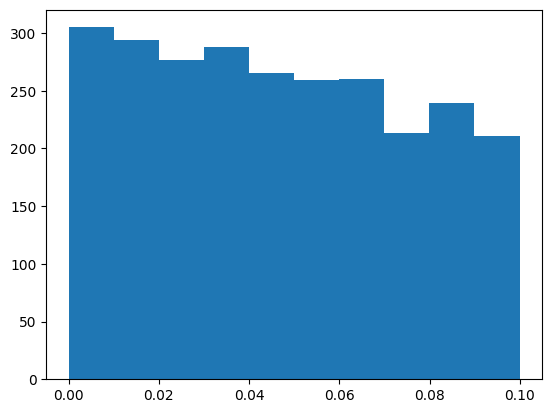

In [65]:
plt.hist(df[df['magnitude']<.1]['magnitude'])

(array([6.058e+03, 1.190e+02, 3.000e+00, 0.000e+00, 0.000e+00, 5.090e+02,
        2.610e+02, 3.200e+01, 1.500e+01, 3.000e+00]),
 array([0.        , 0.73333333, 1.46666667, 2.2       , 2.93333333,
        3.66666667, 4.4       , 5.13333333, 5.86666667, 6.6       ,
        7.33333333]),
 <BarContainer object of 10 artists>)

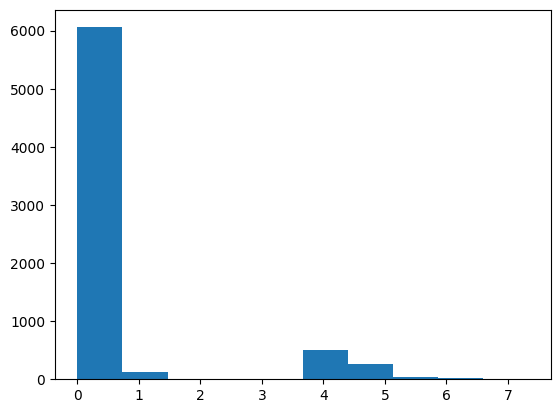

In [61]:
plt.hist(df['score_j'] - df['score_k'])

In [25]:
# joint scoring function
df

,question,source,modj,modk,tokj,tok,response_j,response_k,magnitude,__index_level_0__,nouns_j,nouns_k,tokens_j,tokens_k
0,Can you write a C++ program that prompts the u...,evol_instruct,pythia-12b,alpaca-7b,583,130,Here's a C++ program that prompts the user to ...,int main() {\n string country;\n // prom...,3.75,0,155,36,497,105
1,Can you write a C++ program that prompts the u...,evol_instruct,starchat,alpaca-7b,363,130,Sure! Here's a C++ program that prompts the us...,int main() {\n string country;\n // prom...,2.75,1,85,36,304,105
2,Can you write a C++ program that prompts the u...,evol_instruct,pythia-12b,starchat,583,363,Here's a C++ program that prompts the user to ...,Sure! Here's a C++ program that prompts the us...,1.00,3,155,85,497,304
3,Can you write a C++ program that prompts the u...,evol_instruct,pythia-12b,vicuna-33b,583,276,Here's a C++ program that prompts the user to ...,"Sure, here is the program using the C++11 algo...",3.75,4,155,69,497,227
4,Can you write a C++ program that prompts the u...,evol_instruct,starchat,vicuna-33b,363,276,Sure! Here's a C++ program that prompts the us...,"Sure, here is the program using the C++11 algo...",2.75,5,85,69,304,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Generate an example sentence using the followi...,evol_instruct,alpaca-7b,starchat,28,20,The young entrepreneur was furious at the lack...,Irritability fueled the furious venture of the...,1.00,11239,5,4,21,12
9996,Generate an example sentence using the followi...,evol_instruct,alpaca-7b,ultralm-13b,28,155,The young entrepreneur was furious at the lack...,One possible sentence using the given words is...,1.75,11240,5,26,21,135
9997,Generate an example sentence using the followi...,evol_instruct,bard,starchat,23,20,"After the failure of his latest venture, the b...",Irritability fueled the furious venture of the...,1.00,11241,3,4,16,12
9998,Generate an example sentence using the followi...,evol_instruct,bard,ultralm-13b,23,155,"After the failure of his latest venture, the b...",One possible sentence using the given words is...,1.75,11242,3,26,16,135


In [28]:
df[(df['nouns_j']>df['nouns_k'])==(df['tokens_k']>df['tokens_j'])]

,question,source,modj,modk,tokj,tok,response_j,response_k,magnitude,__index_level_0__,nouns_j,nouns_k,tokens_j,tokens_k
21,How can I convert the decimal number 31 to bin...,evol_instruct,vicuna-33b,wizardlm-13b,241,244,Certainly! You can use the following JavaScrip...,"Sure, I'd be happy to help with that! \n\nIn J...",2.500000,23,47,33,175,191
47,How can we enhance the robotic arm's capabilit...,evol_instruct,mpt-30b-chat,starchat,267,284,To enhance the robotic arm's capabilities for ...,Enhancing the capabilities of a robotic arm fo...,0.500000,51,78,76,229,239
48,How can we enhance the robotic arm's capabilit...,evol_instruct,mpt-30b-chat,ultralm-65b,267,287,To enhance the robotic arm's capabilities for ...,"Yes, it is possible to enhance the capabilitie...",0.500000,52,78,74,229,242
67,Please provide the result of dividing 14 by 6 ...,evol_instruct,mpt-30b-chat,vicuna-33b,473,433,The result of dividing 14 by 6 using long divi...,To perform long division and express the quoti...,1.250000,77,66,68,320,304
86,Provide a concise declaration based on the exi...,evol_instruct,gpt-3.5-turbo,wizardlm-7b,38,22,"Based on the latest available polls, Joe Biden...",Joe Biden is the leading candidate for victory...,0.500000,98,7,7,30,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99971,"Q: In this task, you're given the beginning an...",flan_v2_niv2,gpt-4,mpt-30b-chat,12,12,Maria quickly performed CPR on a choking baby.,In the middle: Maria rushed to the house.,1.666667,112305,4,3,9,10
99978,"TASK DEFINITION: In this task, you're given th...",flan_v2_niv2,vicuna-33b,starchat,15,15,"Sean, a childhood friend, had come back into t...","Sean came over, and I was really pleased to se...",1.250000,112312,4,0,12,13
99979,"TASK DEFINITION: In this task, you're given th...",flan_v2_niv2,ultralm-65b,vicuna-33b,18,15,Sean brought me a surprise.\n\nThe confidence ...,"Sean, a childhood friend, had come back into t...",0.500000,112313,4,4,13,12
99985,TASK DEFINITION: In this task you will be give...,flan_v2_niv2,alpaca-7b,falcon-40b-instruct,156,192,"[[74, -27, 72, 80, -75, 44, 74, 94], [-14, 71,...","`{""result"": [-88, -269, 64, 46, -222, 221, -46...",0.500000,112320,32,19,91,97
